# XGBoost

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb

### Types of Time Series Data

![Types of Time Series Data](https://miro.medium.com/max/1400/1*V_RKPeIxCB9CS_2SsLyKXw.jpeg)

In [5]:
# import csv dataset
df=pd.read_csv('divvy-tripdata_cleaned.csv',index_col=1,parse_dates=True)

# make into dataframe
df2=pd.DataFrame(df)

# which columns to include alongside column acting as index
cols=[3]
df2=df2[df2.columns[cols]]

In [6]:
# sorting the dataframe
df3=df2.sort_values("start_time")
df3.head()

,trip_duration
start_time,
2013-06-30 10:48:00,557
2013-06-30 10:51:00,12496
2013-06-30 11:27:00,699
2013-06-30 11:35:00,1093
2013-06-30 11:56:00,3957


<AxesSubplot:xlabel='start_time'>

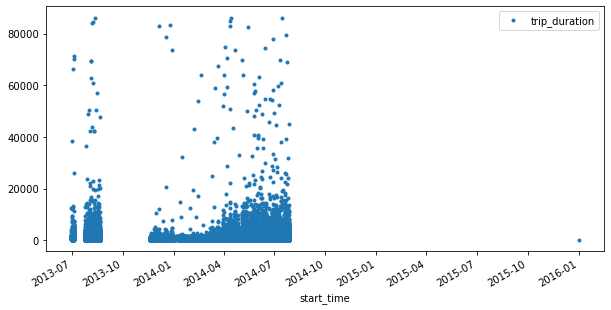

In [9]:
# plotting the data
df3.plot(style='.',figsize=(10,5))